In [0]:
畳み込みニューラルネットワークの第1層の重みを可視化する


In [1]:
# -*- coding: utf-8 -*-
#-*- coding: cp950 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from typing import *

import torch
import torch.optim as optim

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *
from fastai.core import *

import tensorflow as tf
import random as rn
np.random.seed(0)
rn.seed(0)

import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

from keras.preprocessing import image
from sklearn.model_selection import train_test_split

# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
 
import warnings
warnings.filterwarnings('ignore')
import cv2

from keras.applications import ResNet50


Using TensorFlow backend.


In [0]:
os.listdir()

['.ipynb_checkpoints',
 '00Food-11K  Recognition VGG16 OK .ipynb',
 'AI 李宏毅 - HackMD UV.pdf',
 'AI 李宏毅 - HackMD UV2.pdf',
 'cosmos',
 'sakura',
 'simple CNN.ipynb',
 'Transfer Learning  CNN計算 J.pdf',
 'Transfer Learning  feature extraction logistic J.pdf',
 'Transfer Learning  GBT J.pdf',
 'Transfer Learning  logistic J UV.pdf',
 'Transfer Learning  logistic J.pdf',
 'Transfer Learning  傅立葉計算1 J.pdf',
 'Transfer Learning  傅立葉計算2 J.pdf',
 'Transfer Learning  傅立葉計算3 J.pdf',
 'Transfer Learning  櫻花與波斯菊 J.pdf',
 'Transfer Learning  櫻花與波斯菊數據 J.pdf',
 'Transfer Learning  權重可視化 J.pdf',
 'Transfer Learning  權重可視化 J2.pdf']

In [2]:
#在colab下接入google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)
base_dir = '/content/gdrive/My Drive'
#path = Path(base_dir +'/imgs4')  #imgs
path = Path(base_dir +'/DLtry')
path.mkdir(parents=True,exist_ok=True)
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
ここでresnet.summary()と実行すると、ネットワークの構造が出力されます。
その出力をみると、最初の畳み込み層の名前がconv1だとわかるので、その層の重みを取得します。

In [3]:
resnet = ResNet50()
resnet.summary()

102858752/102853048 [==============================] - 7s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [0]:
重み配列のサイズを見てみましょう。以下を実行すると、(7, 7, 3, 64)と出力されます。
畳み込みカーネルの高さと幅がそれぞれ7, 7で、入力が3チャネル（青、緑、赤）、
出力が64チャネルだということがわかります。
これから、64個それぞれのチャネルのカーネルの重みを可視化していきます。

In [4]:
#conv1 (Conv2D)   (None, 112, 112, 64) 9472        
weights = resnet.get_layer("conv1").get_weights()[0]
weights.shape

(7, 7, 3, 64)

In [0]:
まずは0個目のカーネルを可視化してみます。
畳み込み層の重みはどのような範囲の値をとるかわからないので、0から1の範囲に正規化します。
、KerasのResNet50のモデルはRGB形式でなくBGR形式で学習されているため、RGBからBGRに変換します。

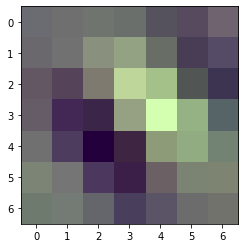

In [5]:
w = weights[:, :, ::-1, 0].copy()
m = w.min()
M = w.max()
w = (w-m)/(M-m)
plt.imshow(w)

In [0]:
すると、次のような画像が出力されます。

 白い線が左上から右下に向かって走っています。この畳み込みカーネルではバックスラッシュ“＼”と同じ方向のエッジを検出できそうです。
 詳しい手順は省略しますが、実際にこの畳み込みカーネルを写真に対して適用すると、以下のように斜め方向のエッジが検出できていることが観察できます。

（上の畳み込みカーネルを左の写真に適用したものが右の画像。）

In [0]:
最後に、64個すべてのカーネルを並べて表示してみましょう。ここでは画像処理ライブラリPillowを使うことにします。
まず、大きい画像をあらわす変数resultを用意します。そして、64枚それぞれのカーネルの可視化をresultの各部分に貼り付けていき、
画像を作成します。

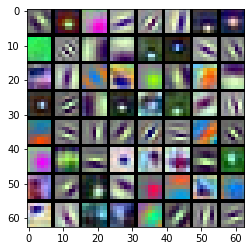

In [9]:
from PIL import Image

result = Image.new("RGB", (7*8+(8-1), 7*8+(8-1)))
for i in range(64):
    w= weights[:, :, ::-1, i].copy()
    M = w.max()
    m = w.min()
    w = (w-m)/(M-m)
    w *= 255
    img = Image.fromarray(w.astype("uint8"), mode="RGB")
    result.paste(img, (7*(i//8) + (i//8), 7*(i%8)+(i%8)))
plt.imshow(result)
